# Distillable Entanglement Estimation for bipartite Qubit-Qutrit pure states

In [106]:
# Importing necessary libraries
from utils import *

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [77]:
states = generate_random_state(1000)

## Entanglement Entropy of qubit-qutrit pure states

Let us lay down some definitions:

Let $\mathcal{H}_A$, $\mathcal{H}_B$ be **Hilbert Spaces** where,

$$ \dim(\mathcal{H}_A) = 2, \quad \dim(\mathcal{H}_B) = 3 $$

Let $\ket{0}_A$, $\ket{1}_A$ be the orthogonal basis states of $\mathcal{H}_A$.
Similarly $\ket{0}_B$, $\ket{1}_B$ and $\ket{2}_B$ be the orthogonal states of $\mathcal{H}_B$.


We will now consider an arbitrary bipartite statevector,  $$\ket{\psi} = a\ket{0}_A \ket{0}_B + b\ket{0}_A\ket{1}_B + c\ket{0}_A\ket{2}_B + d\ket{1}_A \ket{0}_B + e \ket{1}_A \ket{1}_B + f \ket{1}_A \ket{2}_B $$
$$ \ket{\psi} \in \mathcal{H}_A \otimes \mathcal{H}_B $$
Correspondingly, 

$$  \rho = \ket{\psi} \bra{\psi}, \quad \rho \in \mathcal{D}(\mathcal{H}_A \otimes \mathcal{H}_B) $$

The ***Entanglement Entropy*** of the state $\ket{\psi}$ is defined as:

$$ \mathcal{E}(\rho) = \mathcal{S}(\rho_A) = \mathcal{S}(\rho_B) $$

where $\mathcal{S}$ is the *von Neumann Entropy* and $\rho_A$, $\rho_B$ are the reduced subsystems.

From the **Schmidt Decomposition** we can conclude that ranks of the matrices $\rho_A$ and $\rho_B$ and have the same eigenvalues.

From further simplification we find the eigenvalues to be,

$\lambda_\pm  = \dfrac{1 \pm \sqrt{1-4(|ae-bd|^2 + |af-cd|^2 + |bf-ce|^2)}}{2}$

Let us call the parameter to be estimated as $\beta$, then

$$ \lambda_\pm = \dfrac{1 \pm \sqrt{1 - 4\beta}}{2}, \quad 0\leq \beta \leq \frac{1}{4} $$


### UNITARY OPERATOR DEFINITION


States of interest : 

$$ ae : \left(\ket{0}_A \ket{0}_B \ket{1}_A \ket{1}_B \quad \ket{1}_A \ket{1}_B \ket{0}_A \ket{0}_B \right), \quad bd : (\ket{0}_A \ket{1}_B \ket{1}_A \ket{0}_B \quad \ket{1}_A \ket{0}_B \ket{0}_A \ket{1}_B) \implies |ae-bd|^2$$
$$ af : (\ket{0}_A \ket{0}_B \ket{1}_A \ket{2}_B \quad \ket{1}_A \ket{2}_B \ket{0}_A \ket{0}_B), \quad cd : (\ket{0}_A \ket{2}_B \ket{1}_A \ket{0}_B \quad \ket{1}_A \ket{0}_B \ket{0}_A \ket{2}_B) \implies |af-cd|^2$$
$$ bf : (\ket{0}_A \ket{1}_B \ket{1}_A \ket{2}_B \quad \ket{1}_A \ket{2}_B \ket{0}_A \ket{1}_B), \quad ce : (\ket{0}_A \ket{2}_B \ket{1}_A \ket{1}_B) \quad \ket{1}_A \ket{1}_B \ket{0}_A \ket{2}_B) \implies |bf-ce|^2$$

### LOCC 

We will now define a LOCC Protcol for the by measuring the qutrit subsystem and apply local unitary operations depending upon the measured outcome

We propose a of local 2-qubit unitary, that would be used based upon measurement outcomes.

$$ U (\ket{01}) \rightarrow \frac{1}{\sqrt{2}} ( \ket{01} - \ket{10}) $$

$$ U (\ket{10}) \rightarrow \frac{1}{\sqrt{2}} ( \ket{10} + \ket{01}) $$

We measure Bob's pairs of qubits $q_{B1}$ and $q_{B2}$ and transfer them via classical bits with 3 levels namely $(c_1, c_3)$.

If $(c_1 \neq c_3)$, we perform the local unitary operation on Alice's pair of qubits. The condition $(c_1 \neq c_3)$ is equivalent to $((c_1 - c_3)^2 \mod 3) = 1$.

Finally, we measure the relative frequencies of observing either of the following states:

$$ \ket{1}_A \ket{1}_B \ket{0}_A \ket{0}_B, \quad \ket{1}_A \ket{0}_B \ket{0}_A \ket{1}_B \implies |ae-bd|^2$$
$$ \ket{1}_A \ket{2}_B \ket{0}_A \ket{0}_B, \quad \ket{1}_A \ket{0}_B \ket{0}_A \ket{2}_B \implies |af-cd|^2$$
$$ \ket{1}_A \ket{2}_B \ket{0}_A \ket{1}_B, \quad \ket{1}_A \ket{1}_B \ket{0}_A \ket{2}_B \implies |bf-ce|^2$$

By doing so, we obtain the estimate $\hat{\beta}$


In [79]:
local_unitary = np.eye(4)
local_unitary[1, 1] /= np.sqrt(2)
local_unitary[2, 2] /= np.sqrt(2)
local_unitary[2, 1] = -1/np.sqrt(2)
local_unitary[1, 2] = 1/np.sqrt(2)
print(f"LOCAL UNITARY U_L : \n {local_unitary}")

LOCAL UNITARY U_L : 
 [[ 1.          0.          0.          0.        ]
 [ 0.          0.70710678  0.70710678  0.        ]
 [ 0.         -0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.          1.        ]]


In [102]:
def simulation(state, dimA, dimB, shots=100000, history=False):
    pa, pb = partial_traces(state, dimA, dimB)
    pa_, pb_ = tensor(pa, pa), tensor(pb, pb)

    # Post Measurement states
    # The reduced subsystem A is invariant when averaged over all the possible measurement outcomes
    
    transformed = local_unitary@pa_@local_unitary.T
    pa_probs = np.diag(transformed).real
    num_list = [0, 0, 1, 0] # Marking the required state |10>
    choices = np.random.choice(num_list, shots, p=pa_probs)

    if not history:
        return np.sum(choices).item()/shots

    return np.sum(choices).item()/shots, np.cumulative_sum(choices)/np.cumulative_sum(np.ones(shots))

We perform the noiseless simulation on random state

In [108]:
state = states[10]
true_entropy = von_neumann_entropy_from_state(state, 2, 3)

In [104]:
beta, hist = simulation(state, 2, 3, shots=100000, history=True)

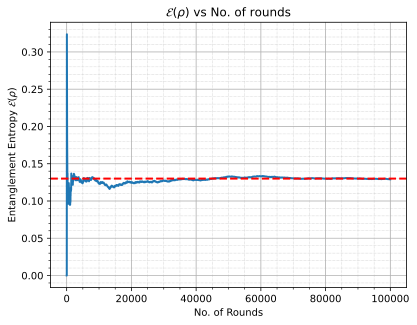

In [118]:
n = 100000

plt.plot(range(n), [von_neumann_S_from_k(i) for i in hist], lw=2)
plt.axhline(true_entropy, ls='dashed', color='red', lw=2)
plt.grid()
plt.grid(which='minor', lw=0.5, ls=':')
plt.minorticks_on()
plt.xlabel("No. of Rounds")
plt.ylabel("Entanglement Entropy $\\mathcal{E}(\\rho)$")
plt.title(" $\\mathcal{E}(\\rho)$ vs No. of rounds ")
plt.show()

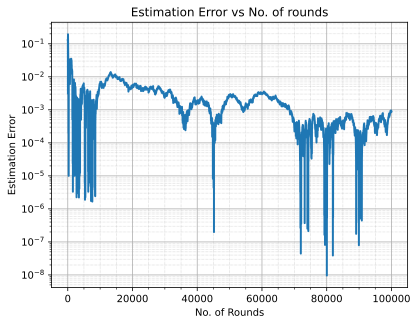

In [121]:
n = 100000

plt.semilogy(range(n), abs(true_entropy - np.array([von_neumann_S_from_k(i) for i in hist])), lw=2)
plt.grid()
plt.grid(which='minor', lw=0.5, ls=':')
plt.minorticks_on()
plt.xlabel("No. of Rounds")
plt.ylabel("Estimation Error")
plt.title("Estimation Error vs No. of rounds")
plt.show()